In [1]:
from keras.models import load_model
from sklearn import preprocessing
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
#!pip install nltk

In [3]:
import nltk
from nltk.util import ngrams
import spacy 
import numpy
import pandas as pd
import seaborn as sns

/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


In [4]:
#%%time
#nlp=spacy.load('en_vectors_web_lg')
%time nlp=spacy.load('./wikipedia-pubmed-and-PMC-w2v')
%time model=load_model('./model/lstm.h5')

/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/cellar/users/btsui/anaconda3/envs/deep_nlp_cpu/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192, got 176
  return f(*args, **kwds)


CPU times: user 46.7 s, sys: 6.64 s, total: 53.4 s
Wall time: 53.2 s
CPU times: user 17.7 s, sys: 6.19 s, total: 23.9 s
Wall time: 27.4 s


In [5]:
def get_features(docs, max_length):
    docs = list(docs)
    Xs = numpy.zeros((len(docs), max_length), dtype='int32')
    for i, doc in enumerate(docs):
        j = 0
        for token in doc:
            ##rever to word vector
            vector_id = token.vocab.vectors.find(key=token.orth)
            if vector_id >= 0:
                Xs[i, j] = vector_id
            else:
                Xs[i, j] = 0
            j += 1
            if j >= max_length:
                break
    return Xs

In [6]:
le = preprocessing.LabelEncoder()
le.classes_ = numpy.load('./model/classes.npy')

### write code for n gram

In [7]:
#sent='Large outbreak of pre-XDR TB Argentina'
#sent='Japanese experience with dual-action antidepressants'
#\n, no 
sent='5 Vertebral column tissue including tail CME242'

Text(0.5,24,'words in sentence')

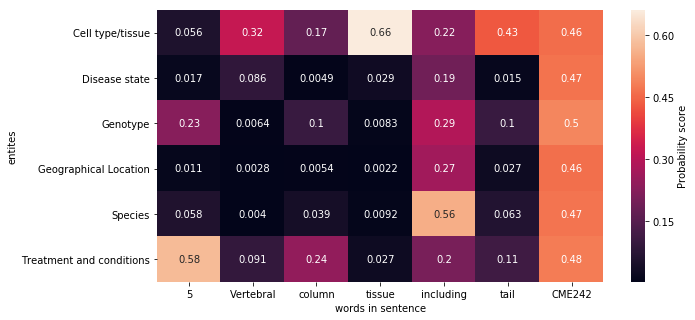

In [8]:
tokens=sent.split(' ')
s=sent.split(' ')

scoreDf=pd.DataFrame(columns=le.classes_,index=tokens).fillna(0)
#for n_gram in range(1,len(tokens)+1):
for n_gram in range(1,len(tokens)):
    grams=list(map(lambda L:" ".join(L),list(ngrams(s,n_gram))))
    #print (grams)
    val_docs = list(nlp.pipe(grams))
    val_X=get_features(val_docs,max_length=model.input_shape[1])
    tmpDf=pd.DataFrame(data=model.predict_proba(val_X),columns=le.classes_,index=grams)
    """
    each n gram only advange 
    """
    for i,word in enumerate(tmpDf.index):
        for j,one_gram in enumerate(word.split(' ')):
            scoreDf.iloc[i+j]=numpy.maximum(scoreDf.iloc[i+j],(tmpDf.iloc[i]))
            
displayHmap=scoreDf.T
fig,ax=plt.subplots(figsize=(10,5))
#displayHmap[displayHmap.max(axis=1)<0.5]=0
sns.heatmap(data=displayHmap,ax=ax,cbar_kws={'label':'Probability score'},annot=True)
ax.set_ylabel('entites')
ax.set_xlabel('words in sentence')

In [9]:
tmpDf

,Cell type/tissue,Disease state,Genotype,Geographical Location,Species,Treatment and conditions
5 Vertebral column tissue including tail,0.033061,0.000125,0.000225,0.000003,0.000199,0.008942
Vertebral column tissue including tail CME242,0.111644,0.000404,0.000130,0.000004,0.000123,0.003277


In [10]:
sent='Human Brain Normal Temporal lobe'

Text(0.5,24,'words in sentence')

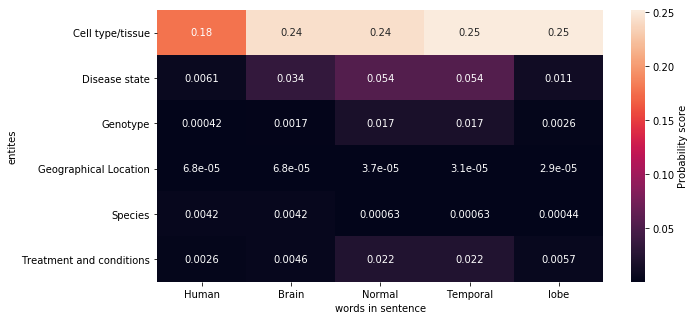

In [11]:
tokens=sent.split(' ')
s=sent.split(' ')

scoreDf=pd.DataFrame(columns=le.classes_,index=tokens).fillna(0)
#for n_gram in range(1,len(tokens)+1):
#for n_gram in range(1,len(tokens)):
n_gram=2
grams=list(map(lambda L:" ".join(L),list(ngrams(s,n_gram))))
#print (grams)
val_docs = list(nlp.pipe(grams))
val_X=get_features(val_docs,max_length=model.input_shape[1])
tmpDf=pd.DataFrame(data=model.predict_proba(val_X),columns=le.classes_,index=grams)
"""
each n gram only advange 
"""
for i,word in enumerate(tmpDf.index):
    for j,one_gram in enumerate(word.split(' ')):
        scoreDf.iloc[i+j]=numpy.maximum(scoreDf.iloc[i+j],(tmpDf.iloc[i]))
            
displayHmap=scoreDf.T
fig,ax=plt.subplots(figsize=(10,5))
#displayHmap[displayHmap.max(axis=1)<0.5]=0
sns.heatmap(data=displayHmap,ax=ax,cbar_kws={'label':'Probability score'},annot=True)
ax.set_ylabel('entites')
ax.set_xlabel('words in sentence')